`./xgboost.ipynb`でXGBoostを使用してGridSearchをしたところ、最良のパラメータが
``` Python
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
}
```
のうち
``` Python
Best parameters: {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 200
    }
```
であった。ここからこれら全てにおいて改善の余地があると判断し、これら3パラメータについてより良い値を探しにいく。

In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [28]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
submission = pd.read_csv("../data/input/sample_submission.csv")

In [29]:
le_personality = LabelEncoder()
le = LabelEncoder()
train["Personality_encoded"] = le_personality.fit_transform(train["Personality"])

In [30]:
categorical_cols = train.select_dtypes(exclude=['number']).columns

for col in categorical_cols:
    train[col] = le.fit_transform(train[col])

In [31]:
X = train.drop(columns=["id", "Personality", "Personality_encoded"])
y = train["Personality_encoded"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [33]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='error',
)

In [34]:
param_grid = {
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'n_estimators': [100, 200, 300, 400],
}
grid_search = GridSearchCV(model, param_grid)
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation score: 0.9688


In [35]:
best_model = grid_search.best_estimator_

In [36]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9714


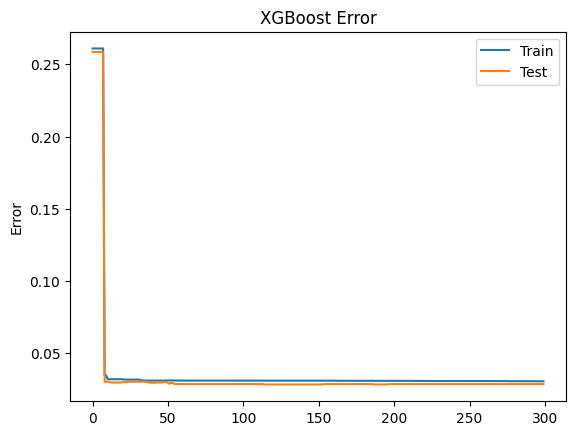

In [37]:
results = best_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

In [38]:
categorical_cols = test.select_dtypes(exclude=['number']).columns

for col in categorical_cols:
    test[col] = le.fit_transform(test[col])

test_predictions = best_model.predict(test.drop(columns=["id"]))
final_predictions = np.array(test_predictions).astype(int)

submission["Personality"] = le_personality.inverse_transform(final_predictions)
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [39]:
submission.to_csv("../data/output/submission_xgboost_gridsearch.csv", index=False)
print("Submission saved to ../data/output/submission_xgboost_gridsearch.csv")

Submission saved to ../data/output/submission_xgboost_gridsearch.csv


In [40]:
!kaggle competitions submit -c playground-series-s5e7 -f ../data/output/submission_xgboost_gridsearch.csv -m "XGBoost with Grid Search"

100%|██████████████████████████████████████| 96.5k/96.5k [00:01<00:00, 98.6kB/s]
Successfully submitted to Predict the Introverts from the Extroverts